In [188]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_excel('C:\\Users\\ZhouK\\Documents\\Python Scripts\\Loan_Tape.xlsx')
pd.options.mode.chained_assignment = None  #Remove warning

In [4]:
#FICO Cleaning
df.loc[df['Borrower FICO'] == '+', 'Borrower FICO'] = 0
df.loc[df['Co-Borrower FICO'] == '+', 'Co-Borrower FICO'] = 0
#If one FICO score, use that as primary FICO score. If two FICO scores, take the lower 
df['FICO']= df[['Borrower FICO','Co-Borrower FICO']].values.min(1) #Minimum FICO
df.loc[df['FICO'] == 0, 'FICO'] = df['Borrower FICO']
df.loc[df['FICO'] == 0, 'FICO'] = df['Co-Borrower FICO']
df['FICO'] = df['FICO'].astype(np.float64) #Fixing a datatype error

In [5]:
#Bin DQ Loans
dq_bins = [-np.inf,0,30,60,90,120,np.inf] 
dq_labels = ['0','30','60','90','120','120+'] #0-30 is considered 30, 30-60 is considered 60, etc.
df['DQ Bin'] = pd.cut(df['Days Late'], bins = dq_bins, labels= dq_labels)
#Bin FICO Loans
fico_bins = np.arange(400,851,50)
fico_labels = ['≤450','>450 and ≤500','>500 and ≤550','>550 and ≤600','>600 and ≤650',
               '>650 and ≤700','>700 and ≤750','>750 and ≤800','>800 and ≤850']
df['FICO Bin'] = pd.cut(df['FICO'], bins = fico_bins, labels = fico_labels)

In [6]:
#Term to Maturity + Seasoning Dataframe
term_df = df[(df['Loan Status'] != 'Paid In Full')] #Dropping Paid In Full 

#Term to Maturity
term_df['Maturity Date'] = pd.to_datetime(term_df['Maturity Date'], errors='coerce') 
as_of_date = datetime.date(year=2017,month=4,day=30) #As of Date
term_df['Term to Maturity'] = (term_df['Maturity Date'] - as_of_date).astype('timedelta64[M]')

#Seasoning 
term_df['First Disbursement Date'] = pd.to_datetime(term_df['First Disbursement Date'], errors='coerce')
term_df['Seasoning'] = (as_of_date - term_df['First Disbursement Date']).astype('timedelta64[M]')

# Dropping loans with 0 Maturity date for WAM calculation (includes Collections)
term_df = term_df[np.isfinite(term_df['Term to Maturity'])] 

In [7]:
#For Weighted Average calcuations
wm = lambda x: np.average(x, weights=df.loc[x.index,'Principal Balance'])
i = {'Current Interest Rate' : wm }    
f = {'FICO' : wm}

In [8]:
Total_Original = df['Original Principal Balance'].sum()
Total_Current = df['Principal Balance'].sum()

In [9]:
#FICO Strats
fico_df = df.groupby('FICO Bin').size().to_frame(name='Loan Count')
fico_df = (fico_df
 .join(df['Principal Balance'].groupby(df['FICO Bin']).mean()).rename(columns={'Principal Balance' : 'Average Balance'})
 .join(df['Principal Balance'].groupby(df['FICO Bin']).sum()).rename(columns={'Principal Balance' : 'Total Balance'})
 .join(df['Principal Balance'].groupby(df['FICO Bin']).sum()/Total_Current).rename(columns={'Principal Balance' : '% of Total Balance'})        
 .join(df.groupby(['FICO Bin']).agg(i).rename(columns = {'Current Interest Rate' : 'WA Interest Rate'}))
          )         
fico_df
#~10% of the pool is below 600 FICO
#make a stacked bar graph by # of balance

,Loan Count,Average Balance,Total Balance,% of Total Balance,WA Interest Rate
FICO Bin,,,,,
≤450,2,12700.095000,25400.19,0.003026,0.103565
>450 and ≤500,6,8690.788333,52144.73,0.006212,0.093887
>500 and ≤550,31,8628.617097,267487.13,0.031865,0.087034
>550 and ≤600,62,9772.937903,605922.15,0.072181,0.084342
>600 and ≤650,155,8404.717032,1302731.14,0.155189,0.103742
>650 and ≤700,249,8402.049157,2092110.24,0.249224,0.098942
>700 and ≤750,274,8169.497810,2238442.40,0.266656,0.082557
>750 and ≤800,176,8071.446989,1420574.67,0.169227,0.069917
>800 and ≤850,43,8691.703488,373743.25,0.044522,0.067157


In [10]:
#Loan Status Breakdown
status_df = df.groupby(['Loan Status']).size().to_frame(name='Loan Count')
status_df = (status_df
 .join(df['Principal Balance'].groupby(df['Loan Status']).mean()).rename(columns={'Principal Balance' : 'Average Balance'})
 .join(df['Principal Balance'].groupby(df['Loan Status']).sum()).rename(columns={'Principal Balance' : 'Total Balance'})
 .join(df['Principal Balance'].groupby(df['Loan Status']).sum()/Total_Current).rename(columns={'Principal Balance' : '% of Total Balance'})        
 .join(df.groupby(['Loan Status']).agg(i).rename(columns = {'Current Interest Rate' : 'WA Interest Rate'}))
 .join(df.groupby(['Loan Status']).agg(f).rename(columns = {'FICO' : 'WA FICO'})) 
         )
status_df
#Interesting that Paid in Full FICO is significantly Lower
#Average FICO of pool is 690

,Loan Count,Average Balance,Total Balance,% of Total Balance,WA Interest Rate,WA FICO
Loan Status,,,,,,
Accelerated,3,10228.083333,30684.25,0.003655,0.128226,632.052918
Collection,18,10717.452222,192914.14,0.022981,0.107463,609.323918
Interest Only,293,11763.816451,3446798.22,0.410602,0.084792,697.730859
Paid In Full,110,-3.971818,-436.90,-0.000052,0.096588,579.638155
Repayment,541,8003.090259,4329671.83,0.515775,0.087749,689.649114
Restructured,35,11281.854571,394864.91,0.047039,0.096658,678.345836


In [11]:
#DQ Information 
dq_df = df.groupby(['DQ Bin']).size().to_frame(name='Loan Count')
dq_df = (dq_df
 .join(df['Principal Balance'].groupby(df['DQ Bin']).mean()).rename(columns={'Principal Balance' : 'Average Balance'})
 .join(df['Principal Balance'].groupby(df['DQ Bin']).sum()).rename(columns={'Principal Balance' : 'Total Balance'})
 .join(df['Principal Balance'].groupby(df['DQ Bin']).sum()/Total_Current).rename(columns={'Principal Balance' : '% of Total Balance'})
 .join(df.groupby(['DQ Bin']).agg(i).rename(columns = {'Current Interest Rate' : 'WA Interest Rate'}))
 .join(df.groupby(['DQ Bin']).agg(f).rename(columns = {'FICO' : 'WA FICO'})) 
     )
dq_df
#Pretty standard -- higher DQ have a trend of higher int rate and lower FICO
#make a stacked bar graph by balance

,Loan Count,Average Balance,Total Balance,% of Total Balance,WA Interest Rate,WA FICO
DQ Bin,,,,,,
0,912,8247.770998,7521967.15,0.896059,0.085638,694.664702
30,38,8673.290000,329585.02,0.039262,0.096810,671.997592
60,13,11528.799231,149874.39,0.017854,0.108176,673.331488
90,7,10065.951429,70461.66,0.008394,0.104453,673.932617
120,2,10347.955000,20695.91,0.002465,0.090817,685.587599
120+,28,10782.582857,301912.32,0.035966,0.110799,616.467039


In [12]:
#Assume that 120+ loans will default to calculate a default % 
default_rate = dq_df.iloc[5,3]
default_rate = (((default_rate*100)/3)*4)/100# Default Rate of ~3.6% in 9 months --> 4.8% Anunual
default_rate


0.047954009200873504

In [62]:
#Default Curve
default_df = term_df.groupby(['Seasoning']).size().to_frame(name='Loan Count')
default_df = (default_df
    .join(term_df['Principal Balance'].groupby(term_df['Seasoning']).sum()).rename(columns={'Principal Balance' : 'Total Balance'})          
    .join(s_df['Principal Balance'].groupby(s_df['Seasoning']).sum()).rename(columns={'Principal Balance' : 'Defaulted Balance'})    
             )
default_df = default_df.fillna(0)
default_df['Default %'] = default_df['Defaulted Balance']/default_df['Total Balance']

curve_1 = np.linspace(0,default_df.loc[6, 'Default %'],7) #insert values for seasoning 0-5
curve_2 = np.linspace(default_df.loc[16,'Default %'],0,13) #insert values for seasoning 17-28

#Filling out values to create a hypothetical default curve
default_df.loc[0:5,'Default %'] = curve_1[0:6]
default_df.loc[7, 'Default %'] = (default_df.loc[6,'Default %'] + default_df.loc[8,'Default %'])/2 
default_df.loc[9, 'Default %'] = (default_df.loc[7,'Default %'] + default_df.loc[10,'Default %'])/2 
default_df.loc[11, 'Default %'] = (default_df.loc[10,'Default %'] + default_df.loc[12,'Default %'])/2 
default_df.loc[15, 'Default %'] = (default_df.loc[14,'Default %'] + default_df.loc[16,'Default %'])/2 
default_df.loc[17:28,'Default %'] = curve_2[1:13]

#Manually Indexing 
default_df.loc[29] = 0
default_df.loc[31] = 0
default_df.loc[33] = 0
default_df.loc[34] = 0
default_df.sort_index(ascending=True)

default_df


,Loan Count,Total Balance,Defaulted Balance,Default %
Seasoning,,,,
0.0,34,380957.94,0.00,0.000000
1.0,67,712318.23,0.00,0.004366
2.0,54,643947.15,0.00,0.008731
3.0,14,184724.42,0.00,0.013097
4.0,46,503842.51,0.00,0.017463
5.0,71,751500.49,0.00,0.021828
6.0,44,517106.02,13545.00,0.026194
7.0,60,611894.49,0.00,0.027224
8.0,34,315878.14,8925.00,0.028255


Text(0.5,0,'Period')

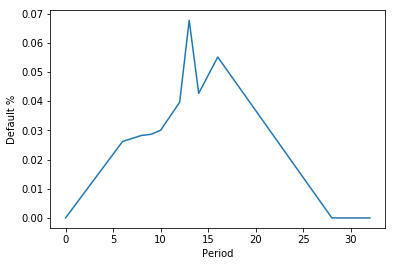

In [15]:
#Plotting a default curve
plt.plot(default_df['Default %'])
plt.ylabel('Default %')
plt.xlabel('Period')

In [16]:
#Seasoning Stratification by balance 0-34
seasoning_bins = np.arange(0,33,4)
seasoning_labels = ['≤4','>4 and ≤8','>8 and ≤12','>12 and ≤16','>16 and ≤20',
                    '>20 and ≤24','>24 and ≤28','>28 and ≤32']
term_df['Seasoning Bin'] = pd.cut(term_df['Seasoning'], bins = seasoning_bins, labels = seasoning_labels)
#Term to Maturity Stratification by Balance
term_bins = np.arange(0,70,10)
term_labels = ['≤10','>10 and ≤20','>20 and ≤30','>30 and ≤40','>40 and ≤50',
                    '>50 and ≤60']
term_df['Maturity Bin'] = pd.cut(term_df['Term to Maturity'], bins = term_bins, labels = term_labels)

In [17]:
#Seasoning Strats
seasoning_df = term_df.groupby(['Seasoning Bin']).size().to_frame(name='Loan Count')
seasoning_df = (seasoning_df
 .join(term_df['Principal Balance'].groupby(term_df['Seasoning Bin']).mean()).rename(columns={'Principal Balance' : 'Average Balance'})
 .join(term_df['Principal Balance'].groupby(term_df['Seasoning Bin']).sum()).rename(columns={'Principal Balance' : 'Total Balance'})
 .join(term_df['Principal Balance'].groupby(term_df['Seasoning Bin']).sum()/Total_Current).rename(columns={'Principal Balance' : '% of Total Balance'})
               )
seasoning_df

,Loan Count,Average Balance,Total Balance,% of Total Balance
Seasoning Bin,,,,
≤4,181,11297.416077,2044832.31,0.243592
>4 and ≤8,209,10508.991100,2196379.14,0.261645
>8 and ≤12,137,10241.076058,1403027.42,0.167137
>12 and ≤16,133,8404.646617,1117818.00,0.133161
>16 and ≤20,77,7103.679351,546983.31,0.065160
>20 and ≤24,54,5572.780741,300930.16,0.035849
>24 and ≤28,35,4499.106857,157468.74,0.018759
>28 and ≤32,10,2884.927000,28849.27,0.003437


In [18]:
#School Strats
school_df = df.groupby(['School']).size().to_frame(name='Loan Count')
school_df =school_df[school_df['Loan Count'] > 5]

school_df = (school_df
 .join(df['Principal Balance'].groupby(df['School']).mean()).rename(columns={'Principal Balance' : 'Average Balance'})
 .join(df['Principal Balance'].groupby(df['School']).sum()).rename(columns={'Principal Balance' : 'Total Balance'})
 .join(df['Principal Balance'].groupby(df['School']).sum()/Total_Current).rename(columns={'Principal Balance' : '% of Total Balance'}) 
               )
school_df
#maybe top 10 schools by loan count, average balance? total balance?

,Loan Count,Average Balance,Total Balance,% of Total Balance
School,,,,
School 11,18,5426.154444,97670.78,0.011635
School 13,50,13763.653600,688182.68,0.081980
School 14,243,7965.298683,1935567.58,0.230576
School 16,7,7701.644286,53911.51,0.006422
School 17,17,7603.837647,129265.24,0.015399
School 18,33,9661.994545,318845.82,0.037983
School 19,7,3643.475714,25504.33,0.003038
School 20,9,6455.403333,58098.63,0.006921
School 21,26,5559.593846,144549.44,0.017220


In [19]:
ttm_df = term_df.groupby(['Maturity Bin']).size().to_frame(name='Loan Count')
ttm_df = (ttm_df
 .join(term_df['Principal Balance'].groupby(term_df['Maturity Bin']).mean()).rename(columns={'Principal Balance' : 'Average Balance'})
 .join(term_df['Principal Balance'].groupby(term_df['Maturity Bin']).sum()).rename(columns={'Principal Balance' : 'Total Balance'})
 .join(term_df['Principal Balance'].groupby(term_df['Maturity Bin']).sum()/Total_Current).rename(columns={'Principal Balance' : '% of Total Balance'})
               )
ttm_df

,Loan Count,Average Balance,Total Balance,% of Total Balance
Maturity Bin,,,,
≤10,8,2674.416250,21395.33,0.002549
>10 and ≤20,86,4573.178256,393293.33,0.046851
>20 and ≤30,228,7484.909561,1706559.38,0.203295
>30 and ≤40,492,10694.485447,5261686.84,0.626802
>40 and ≤50,14,10903.292143,152646.09,0.018184
>50 and ≤60,42,15277.745714,641665.32,0.076439


In [20]:
#Total Balance, Number of Loans, Avg Loan size, WA Rate, WA FICO, Loan Status%, WA Seasoning, WA IO, Days late (30,60,90,120+),
#Breakdown of School characteristics, plot rate based on origination date,top 20 loans at risk
#cash flow with no prepayment rate, realistic prepayment rate
#calculate prepayment rate?

Pool_Factor = df['Principal Balance'].sum()/df['Original Principal Balance'].sum()
Loan_Count = df['Loan #'].count()
Avg_Loan = Total_Current/Loan_Count
WA_Rate = np.average(df['Current Interest Rate'], weights = df['Principal Balance'])
WA_FICO = np.average(df['FICO'], weights = df['Principal Balance'])
WAM = np.average(term_df['Term to Maturity'], weights = term_df['Principal Balance'])
WA_Seasoning = np.average(term_df['Seasoning'], weights = term_df['Principal Balance']) #add months
WA_Original_Term = np.average(term_df['Original Repayment Period (Months)'], weights = term_df['Principal Balance'])
WA_IO = np.average(term_df['Original Interest Only Period (Months)'], weights = term_df['Principal Balance'])
Current_Pct = dq_df.loc['0','% of Total Balance'] 

top_twenty = df.nlargest(20,columns='Principal Balance')
top_20 = top_twenty['Principal Balance'].sum()/Total_Current #Top 20 loans by loan balance

In [236]:
#Creating the Comps of the portfolio
Data = {'Total Original Balance' : Total_Original,
        'Total Current Balance' : Total_Current,
        'Pool Factor' : Pool_Factor,
        'Loan Count' : Loan_Count,
        'Average Loan Amount' : Avg_Loan,
        'WA Interest Rate' : WA_Rate,
        'WA FICO' : WA_FICO,
        'WA Term to Maturity (Months)' : WAM,
        'WA Seasoning (Months)' : WA_Seasoning,
        'WA Original Term (Months)' : WA_Original_Term,
        'WA Original Interest Only Term (Months)' : WA_IO,
        '% of Loans Current' : Current_Pct,
        'Top 20 Largest Loans (% of Balance)' : top_20}

Data_Dict = {k:[v] for k,v in Data.items()}
#Re-ordering columns
Comps = pd.DataFrame(Data_Dict, columns = ['Total Original Balance','Total Current Balance', 'Pool Factor', 'Loan Count','Average Loan Amount',
                                          'WA Interest Rate','WA FICO','WA Term to Maturity (Months)','WA Seasoning (Months)',
                                          'WA Original Term (Months)','WA Original Interest Only Term (Months)'
                                          ,'% of Loans Current','Top 20 Largest Loans (% of Balance)'])

Comps = Comps.T
Comps = Comps.rename(columns = {0:"Comps"})


,Comps
Total Original Balance,1.075539e+07
Total Current Balance,8.394496e+06
Pool Factor,7.804923e-01
Loan Count,1.000000e+03
Average Loan Amount,8.394496e+03
WA Interest Rate,8.755450e-02
WA FICO,6.903850e+02
WA Term to Maturity (Months),3.322314e+01
WA Seasoning (Months),8.581319e+00
WA Original Term (Months),3.821110e+01


In [23]:
#Hypothetical Prepayment Rate: Calculate Amortization schedule with
#Values are taken from Climb Strats.py 
#8.755% Int Rate, 42 month Loan Term (WA Term to Maturity + WA Seasoning), Total Original Balance of $10,755,386.38
#Prepayment rate will be (Scheduled Balance - Total Current Balance of Tape)/Total Original Balance
#Current tape is seasoned about 8.58 months so look at the amortization value at 9 months

Months_1 = 42
pmt = np.pmt(WA_Rate/12,Months_1,Total_Original)

#Create the Hypothetical Table of a 42 month term amortization
month_index = np.arange(1,43,1)
amort_df = pd.DataFrame(index = month_index, 
                          columns = ['Payment','Interest','Principal',
                                     'Current Balance','Cumulative Principal'])

amort_df.index.names = ['Month']
amort_df['Payment'] = pmt
amort_df['Interest']= np.ipmt(WA_Rate/12,amort_df.index,Months_1,Total_Original)
amort_df['Principal'] = np.ppmt(WA_Rate/12,amort_df.index,Months_1,Total_Original)

amort_df['Cumulative Principal'] = amort_df['Principal'].cumsum()
amort_df["Cumulative Principal"] = amort_df["Cumulative Principal"].clip(lower=-Total_Original)
amort_df['Current Balance'] = Total_Original + amort_df['Cumulative Principal']
amort_df.loc[42,'Current Balance'] = 0 #Manually fix the Current Balance to 0
amort_df

,Payment,Interest,Principal,Current Balance,Cumulative Principal
Month,,,,,
1,-298244.062141,-78473.540644,-219770.521497,1.053562e+07,-2.197705e+05
2,-298244.062141,-76870.049115,-221374.013026,1.031424e+07,-4.411445e+05
3,-298244.062141,-75254.858177,-222989.203964,1.009125e+07,-6.641337e+05
4,-298244.062141,-73627.882470,-224616.179671,9.866636e+06,-8.887499e+05
5,-298244.062141,-71989.036009,-226255.026132,9.640381e+06,-1.115005e+06
6,-298244.062141,-70338.232183,-227905.829958,9.412476e+06,-1.342911e+06
7,-298244.062141,-68675.383748,-229568.678393,9.182907e+06,-1.572479e+06
8,-298244.062141,-67000.402824,-231243.659317,8.951663e+06,-1.803723e+06
9,-298244.062141,-65313.200891,-232930.861250,8.718732e+06,-2.036654e+06


In [24]:
#Calculate Prepayment Percentage
Prepaid_Amount = amort_df.loc[9, 'Current Balance'] - Total_Current #Scheduled Balance at 9 months - Current Balance
Pp_pool= Prepaid_Amount/Total_Original
Pp_pool #3% of the pool has prepaid in 9 months(Seasoning of the pool is ~8.5) so will assume a 4% CPR

0.030146379250032163

In [ ]:
#Calculate Planned Amortization and Actual Amortization (w/ default, prepayment, recovery)
#As of Date = 04/30/2017 (assume first period will pay 05-01-2017)
#WA Rate: 8.755% --Assuming no WAC deterioration 
#Prepayment Percentage: 4%
#Apply the Default Curve
#Constant Recovery Rate: 20% of Defaulted Principal (80% severity)
#Current WA Term to Maturity : 34 months

In [25]:
#Planned Amortization of the pool
first_pay = datetime.date(year=2017,month=4,day=30) 
periods = pd.date_range(first_pay, periods=34, freq='MS')
periods.name = "Payment Date"

Months_2 = 34

pmt2 = np.pmt(WA_Rate/12,Months_2,Total_Current)

amort_df2 = pd.DataFrame(index = periods, 
                          columns = ['Payment','Interest','Principal',
                                     'Current Balance','Cumulative Principal'])
amort_df2.reset_index(inplace=True)
amort_df2.index += 1
amort_df2.index.name = "Period"

amort_df2['Payment'] = pmt2
amort_df2['Interest']= np.ipmt(WA_Rate/12,amort_df2.index,Months_2,Total_Current)
amort_df2['Principal'] = np.ppmt(WA_Rate/12,amort_df2.index,Months_2,Total_Current)

amort_df2['Cumulative Principal'] = amort_df2['Principal'].cumsum()
amort_df2["Cumulative Principal"] = amort_df2["Cumulative Principal"].clip(lower=-Total_Current)
amort_df2['Current Balance'] = Total_Current + amort_df2['Cumulative Principal']
amort_df2.loc[34,'Current Balance'] = 0 #Manually fix the Current Balance to 0

,Payment Date,Payment,Interest,Principal,Current Balance,Cumulative Principal
Period,,,,,,
1,2017-05-01,-279680.842086,-61247.995663,-218432.846423,8.176064e+06,-2.184328e+05
2,2017-06-01,-279680.842086,-59654.264090,-220026.577996,7.956037e+06,-4.384594e+05
3,2017-07-01,-279680.842086,-58048.904319,-221631.937767,7.734405e+06,-6.600914e+05
4,2017-08-01,-279680.842086,-56431.831509,-223249.010577,7.511156e+06,-8.833404e+05
5,2017-09-01,-279680.842086,-54802.960199,-224877.881887,7.286278e+06,-1.108218e+06
6,2017-10-01,-279680.842086,-53162.204304,-226518.637782,7.059760e+06,-1.334737e+06
7,2017-11-01,-279680.842086,-51509.477112,-228171.364974,6.831588e+06,-1.562908e+06
8,2017-12-01,-279680.842086,-49844.691279,-229836.150808,6.601752e+06,-1.792744e+06
9,2018-01-01,-279680.842086,-48167.758820,-231513.083266,6.370239e+06,-2.024257e+06


In [251]:
#Creates an Amortization Table

#Inputs: 

#Payment: Scheduled payment per month
#Months: Months til maturity of the loan (Calculated by Weighted Average Term to Maturity in Strats)
#Principal: Principal to be paid off(Current Balance of the Tape)
#Prepayment: Prepayment Rate as a % of the principal(Calculated Above)
#Default: Default Curve (Rate taken as a % of the principal)
#Date: As of Date of the tape


def amortization_table(interest_rate, months, principal, prepayment, default, 
                      date=datetime.date(year=2017,month=4,day=30)):


    period = pd.date_range(date, periods=months, freq='MS')
    period.name = "Payment_Date"

    df = pd.DataFrame(index = period,
                    columns = ['Payment','Interest','Principal',
                               'Prepaid_Principal', 'Defaulted', 'Cumulative_Principal',
                               'Current_Balance', 'Recovered', 'CF_To_Investor'])
                      
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"

    pmt = np.pmt(interest_rate,months,principal)

    df['Payment'] = pmt

    #Set period 1 values
    df.loc[1,'Interest'] = -(interest_rate/12)*principal
    df.loc[1, 'Defaulted'] = -((default.loc[1,'Default %']/12) * Total_Current)
    df.loc[1, 'Principal'] = df.loc[1, 'Payment'] - df.loc[1, 'Interest']
    df.loc[1, 'Prepaid_Principal'] = -(prepayment * principal)
    df.loc[1, 'Cumulative_Principal'] = df.iloc[0,2:6].sum()
    df.loc[1, 'Current_Balance'] = principal + df.loc[1, 'Cumulative_Principal']
    df.loc[1, 'Recovered'] = -(df.loc[1, 'Defaulted'] * 0.2)
    df.loc[1, 'CF_To_Investor'] = -(df.loc[1, 'Cumulative_Principal']) + df.loc[1, 'Defaulted'] + df.loc[1,'Recovered']

    iter = np.arange(2,months,1)
    for k in iter:
        df.loc[k, 'Interest'] = -(interest_rate/12)*df.loc[k-1,'Current_Balance']
        df.loc[k, 'Defaulted'] = -((default.loc[k,'Default %']/12) * df.loc[k-1,'Current_Balance'])
        df.loc[k, 'Principal'] = df.loc[k, 'Payment'] - df.loc[k, 'Interest']
        df.loc[k, 'Prepaid_Principal'] = -(prepayment * df.loc[k-1,'Current_Balance'])
        df.loc[k, 'Cumulative_Principal'] = df.iloc[k-1,2:6].sum() #Total Principal being paid off (Includes P&I, Prepaid & Default)
        df.loc[k, 'Current_Balance'] = df.loc[k-1,'Current_Balance'] + df.loc[k, 'Cumulative_Principal']
        df.loc[k, 'Recovered'] = -(df.loc[k, 'Defaulted'] * 0.2) #Assume 80% severity for defaults
        df.loc[k, 'CF_To_Investor'] = -(df.loc[k, 'Cumulative_Principal']) + df.loc[k, 'Defaulted'] + df.loc[1,'Recovered']
        
    #Cap the Current Balance at 0
    df['Current_Balance'] = df['Current_Balance'].clip(lower = 0)
    #Determine last payment date
    try: 
        last_pay = df.query('Current_Balance <= 0')['Current_Balance'].idxmax(axis = 1, skipna=True)
    except ValueError:
        last_pay = df.last_valid_index()
    
    #Drop all extra rows 
    df = df.drop(df.index[last_pay:months])
        
    #Calculate values for the last month
    df.loc[last_pay, 'Interest'] = -(df.loc[last_pay - 1, 'Current_Balance'] * interest_rate/12)
    df.loc[last_pay, 'Principal'] = -(df.loc[last_pay - 1, 'Current_Balance'])
    df.loc[last_pay, 'Prepaid_Principal'] = 0
    df.loc[last_pay, 'Defaulted'] = 0
    df.loc[last_pay, 'Payment'] = df.loc[last_pay, 'Interest'] + df.loc[last_pay, 'Principal']
    df.loc[last_pay, 'Cumulative_Principal'] = df.loc[last_pay, 'Payment']
    
    return df

In [260]:
#Different Scenarios
amort = amortization_table(WA_Rate/12,34,Total_Current,cpr,default_df) #Actual Amortization with CPR 4%
amort_cpr8 = amortization_table(WA_Rate/12,34,Total_Current,0.08/12,default_df) #CPR 8%
amort_cpr12 = amortization_table(WA_Rate/12,34,Total_Current,0.12/12,default_df) #CPR 12%

Text(0.5,1,'Pay Off Timelines')

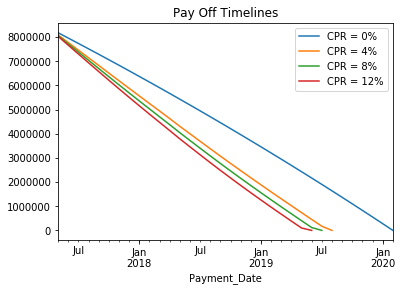

In [219]:
fig, ax = plt.subplots(1,1)
amort_df2.plot(x='Payment Date', y = 'Current Balance', label = 'CPR = 0%', ax = ax)
amort.plot(x='Payment_Date', y = 'Current_Balance', label = 'CPR = 4%', ax=ax)
amort_cpr8.plot(x='Payment_Date', y = 'Current_Balance', label = 'CPR = 8%', ax=ax)
amort_cpr12.plot(x='Payment_Date', y = 'Current_Balance', label = 'CPR = 12%', ax=ax)

plt.title('Pay Off Timelines')

In [293]:
#Show cash flows and default amounts for different CPR assumptions
CF = pd.DataFrame(amort['CF_To_Investor']).rename(columns = {'CF_To_Investor' : 'CPR 4% CF'})
CF = (CF.join(pd.DataFrame(amort_cpr8['CF_To_Investor']).rename(columns = {'CF_To_Investor' : 'CPR 8% CF'}))
      .join(pd.DataFrame(amort_cpr12['CF_To_Investor']).rename(columns = {'CF_To_Investor' : 'CPR 12% CF'}))
      .join(pd.DataFrame(amort['Defaulted']).rename(columns = {'Defaulted' : 'CPR 4% Defaulted'}))
      .join(pd.DataFrame(amort_cpr8['Defaulted']).rename(columns = {'Defaulted' : 'CPR 8% Defaulted'}))
      .join(pd.DataFrame(amort_cpr12['Defaulted']).rename(columns = {'Defaulted' : 'CPR 12% Defaulted'}))
     )
CF.fillna(0)
CF.append(CF.sum().rename('Total'))

,CPR 4% CF,CPR 8% CF,CPR 12% CF,CPR 4% Defaulted,CPR 8% Defaulted,CPR 12% Defaulted
Period,,,,,,
1,308273,336255,364237,-3053.95,-3053.95,-3053.95
2,307238,333997,360570,-5881.82,-5861.46,-5841.1
3,306196,331735,356912,-8481.65,-8421.93,-8362.41
4,305149,329472,353265,-10851.8,-10735.1,-10619.2
5,304098,327208,349632,-12991.1,-12801.2,-12613.2
6,303043,324945,346016,-14898.5,-14620.6,-14346.5
7,301985,322685,342419,-14764.6,-14426.7,-14094.6
8,300931,320442,338860,-14579,-14180.4,-13790.1
9,299882,318215,335339,-14022.6,-13573.1,-13134.5


In [479]:
#Function to calculate bond notes pay off
#Inputs: Cashflow series and Default series

def bondpayoff(cashflow,default):
    
    last_pay = cashflow.last_valid_index() #Last period of the cash flows
    
    period = pd.date_range(datetime.date(year=2017,month=4,day=30), periods=last_pay, freq='MS')
    period.name = "Payment_Date"

    df = pd.DataFrame(index = period,
                    columns = ['Cash_Flow','Senior_Balance','Senior_Interest', 'Senior_Principal', 
                               'Senior_EndBalance','Sub_Balance', 'Sub_Interest', 
                               'Sub_Principal', 'Sub_Default', 'Sub_EndBalance'])
                      
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"
    
    #Interest rate for the notes
    senior_int = 0.07/12
    sub_int = 0.1/12 #Assume 10% rate for the sub note
    
    #Input the cashflows being received per period
    df['Cash_Flow'] = cashflow
    df['Sub_Default'] = default
        
    #Set Period 1 values
    df.loc[1, 'Senior_Balance'] = 5480930
    df.loc[1, 'Sub_Balance'] = 2755386
    
    #Pay Interest First
    df.loc[1, 'Senior_Interest'] = df.loc[1, 'Senior_Balance'] * senior_int
    df.loc[1, 'Sub_Interest'] = df.loc[1, 'Sub_Balance'] * sub_int
    
    #Pay down Principal
    df.loc[1, 'Senior_Principal'] = df.loc[1, 'Cash_Flow'] - df.loc[1, 'Senior_Interest'] - df.loc[1, 'Sub_Interest']
    df.loc[1, 'Sub_Principal'] = 0
    
    #Ending Balances
    df.loc[1, 'Senior_EndBalance'] = df.loc[1, 'Senior_Balance'] - df.loc[1, 'Senior_Principal']
    df.loc[1, 'Sub_EndBalance'] = df.loc[1, 'Sub_Balance'] + df.loc[1, 'Sub_Default']
    
    #Iterate until the Senior Note is Paid off
    k = 2
    while df.loc[k-1, 'Senior_EndBalance'] > 0:
    
        df.loc[k, 'Senior_Balance'] = df.loc[k-1, 'Senior_EndBalance']
        df.loc[k, 'Sub_Balance'] = df.loc[k-1, 'Sub_EndBalance']
        
        df.loc[k, 'Senior_Interest'] = df.loc[k, 'Senior_Balance'] * senior_int
        df.loc[k, 'Sub_Interest'] = df.loc[k, 'Sub_Balance'] * sub_int
        
        df.loc[k, 'Senior_Principal'] = df.loc[k, 'Cash_Flow'] - df.loc[k, 'Senior_Interest'] - df.loc[k, 'Sub_Interest']
        df.loc[k, 'Sub_Principal'] = 0
        
        df.loc[k, 'Senior_EndBalance'] = df.loc[k, 'Senior_Balance'] - df.loc[k, 'Senior_Principal']
        df.loc[k, 'Sub_EndBalance'] =df.loc[k, 'Sub_Balance'] + df.loc[k, 'Sub_Default']
        
        k+= 1
        
    #Cap the Current Balance at 0
    df['Senior_EndBalance'] = df['Senior_EndBalance'].clip(lower = 0)
    df['Sub_EndBalance'] = df['Sub_EndBalance'].clip(lower=0)
    #Determine last payment date
    try: 
        last_senior = df.query('Senior_EndBalance <= 0')['Senior_EndBalance'].idxmax(axis = 1, skipna=True)
    except ValueError:
        last_senior = df.last_valid_index()
        
    #Set last payment period for senior note 
    df.loc[last_senior, 'Senior_Principal'] = df.loc[last_senior-1, 'Senior_EndBalance']
    df.loc[last_senior, 'Sub_Principal'] = df.loc[last_senior, 'Cash_Flow'] - df.loc[last_senior, 'Senior_Principal'] - df.loc[last_senior, 'Senior_Interest']
    df.loc[last_senior, 'Sub_EndBalance'] = df.loc[last_senior - 1, 'Sub_EndBalance'] - df.loc[last_senior, 'Sub_Interest'] - df.loc[last_senior, 'Sub_Principal'] + df.loc[last_senior, 'Sub_Default']
    
    #Iterate the payoff of the sub note since the senior note has already paid off
    iter = np.arange(last_senior,last_pay,1)
    for i in iter:
        df.iloc[i,2:6] = 0 #All senior columns will be 0
        df.loc[i, 'Sub_Balance'] = df.loc[i-1, 'Sub_EndBalance']
        df.loc[i, 'Sub_Interest'] = df.loc[i, 'Sub_Balance'] * sub_int
        df.loc[i, 'Sub_Principal'] = df.loc[i, 'Cash_Flow'] - df.loc[i, 'Sub_Interest']
        df.loc[i, 'Sub_EndBalance'] = df.loc[i, 'Sub_Balance'] - df.loc[i, 'Sub_Interest'] - df.loc[i, 'Sub_Principal'] + df.loc[i, 'Sub_Default']
    
    #Calculate values for the last month
        df.loc[last_pay, 'Sub_Balance'] = df.loc[last_pay-1, 'Sub_EndBalance']
        df.loc[last_pay, 'Sub_Interest'] = df.loc[last_pay, 'Sub_Balance'] * sub_int
        df.loc[last_pay, 'Sub_Principal'] = df.loc[last_pay, 'Cash_Flow'] - df.loc[last_pay, 'Sub_Interest']
        df.loc[last_pay, 'Sub_EndBalance'] = df.loc[last_pay, 'Sub_Balance'] - df.loc[last_pay, 'Sub_Interest'] - df.loc[last_pay, 'Sub_Principal'] + df.loc[last_pay, 'Sub_Default']
                                             
    return df

In [492]:
#Cash flows for the notes
payoff = bondpayoff(CF['CPR 4% CF'],CF['CPR 4% Defaulted'])
#payoff['Sub_Default'].sum()
payoff

,Payment_Date,Cash_Flow,Senior_Balance,Senior_Interest,Senior_Principal,Senior_EndBalance,Sub_Balance,Sub_Interest,Sub_Principal,Sub_Default,Sub_EndBalance
Period,,,,,,,,,,,
1,2017-05-01,308273,5480930,31972.1,253340,5.22759e+06,2755386,22961.5,0,-3053.95,2.75233e+06
2,2017-06-01,307238,5.22759e+06,30494.3,253807,4.97378e+06,2.75233e+06,22936.1,0,-5881.82,2.74645e+06
3,2017-07-01,306196,4.97378e+06,29013.7,254295,4.71949e+06,2.74645e+06,22887.1,0,-8481.65,2.73797e+06
4,2017-08-01,305149,4.71949e+06,27530.3,254802,4.46469e+06,2.73797e+06,22816.4,0,-10851.8,2.72712e+06
5,2017-09-01,304098,4.46469e+06,26044,255328,4.20936e+06,2.72712e+06,22726,0,-12991.1,2.71413e+06
6,2017-10-01,303043,4.20936e+06,24554.6,255870,3.95349e+06,2.71413e+06,22617.7,0,-14898.5,2.69923e+06
7,2017-11-01,301985,3.95349e+06,23062,256429,3.69706e+06,2.69923e+06,22493.6,0,-14764.6,2.68446e+06
8,2017-12-01,300931,3.69706e+06,21566.2,256994,3.44006e+06,2.68446e+06,22370.5,0,-14579,2.66988e+06
9,2018-01-01,299882,3.44006e+06,20067,257565,3.1825e+06,2.66988e+06,22249,0,-14022.6,2.65586e+06


Text(0.5,1,'Note Pay Off Timelines')

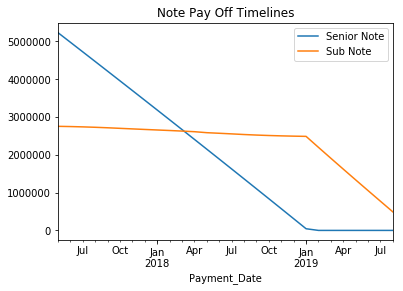

In [489]:
#Amortization of the notes

fig, ax = plt.subplots(1,1)
payoff.plot(x='Payment_Date', y = 'Senior_EndBalance', label = 'Senior Note', ax = ax)
payoff.plot(x='Payment_Date', y = 'Sub_EndBalance', label = 'Sub Note', ax=ax)

plt.title('Note Pay Off Timelines')

In [488]:
payoff_CF = pd.DataFrame(payoff['Senior_Interest'])
payoff_CF = (payoff_CF.join(payoff['Senior_Principal'])
             .join(payoff['Sub_Interest'])
             .join(payoff['Sub_Principal'])
            )
payoff_CF['Senior_Payments'] = payoff_CF['Senior_Interest'] + payoff_CF['Senior_Principal']
payoff_CF['Sub_Payments'] = payoff_CF['Sub_Interest'] + payoff_CF['Sub_Principal']

payoff_CF.append(payoff_CF.sum().rename('Total'))

,Senior_Interest,Senior_Principal,Sub_Interest,Sub_Principal,Senior_Payments,Sub_Payments
Period,,,,,,
1,31972.1,253340,22961.5,0,285312,22961.5
2,30494.3,253807,22936.1,0,284301,22936.1
3,29013.7,254295,22887.1,0,283309,22887.1
4,27530.3,254802,22816.4,0,282333,22816.4
5,26044,255328,22726,0,281372,22726
6,24554.6,255870,22617.7,0,280425,22617.7
7,23062,256429,22493.6,0,279491,22493.6
8,21566.2,256994,22370.5,0,278561,22370.5
9,20067,257565,22249,0,277632,22249


In [515]:
#Pricing the notes with a simple DCF
dcf = pd.DataFrame(payoff_CF['Senior_Payments'])
dcf = dcf.join(payoff_CF['Sub_Payments'])

dcf['Senior_DCF'] = dcf['Senior_Payments']/(1+0.07/12) ** dcf.index
dcf['Sub_DCF'] = dcf['Sub_Payments']/(1+0.1/12) ** dcf.index

dcf.append(dcf.sum().rename('Total'))

,Senior_Payments,Sub_Payments,Senior_DCF,Sub_DCF
Period,,,,
1,285312,22961.5,283657,22771.8
2,284301,22936.1,281013,22558.6
3,283309,22887.1,278408,22324.3
4,282333,22816.4,275840,22071.4
5,281372,22726,273307,21802.3
6,280425,22617.7,270807,21519.1
7,279491,22493.6,268341,21224.1
8,278561,22370.5,265896,20933.6
9,277632,22249,263473,20647.8


In [517]:
#FV of the notes (total payments)
print(dcf['Senior_Payments'].sum())
print(dcf['Sub_Payments'].sum())

5838099.62672
2446656.20671


In [516]:
#PV of the notes
print(dcf['Senior_DCF'].sum())
print(dcf['Sub_DCF'].sum()) 

5480930.0
2036013.9222


In [518]:
#Export data to excel

writer = pd.ExcelWriter('Output.xlsx', engine='xlsxwriter')
#Write each DataFrame to a different sheet

Comps.to_excel(writer, sheet_name = 'Comps') #Comps of the pool
fico_df.to_excel(writer, sheet_name = 'FICO') #FICO Strats
status_df.to_excel(writer, sheet_name = 'Loan Status') #Loan Status Strats
ttm_df.to_excel(writer, sheet_name = 'Maturity') #Maturity Strats
dq_df.to_excel(writer,sheet_name = 'DQ') #DQ Strats
default_df.to_excel(writer, sheet_name = 'Default') #Default Strats
seasoning_df.to_excel(writer, sheet_name = 'Seasoning') #Seasoning Strats
school_df.to_excel(writer, sheet_name = 'School') #School Strats
amort.to_excel(writer, sheet_name = 'Pool Amort') #Amortization of the pool
CF.to_excel(writer, sheet_name = 'CPR CFs') #Cash flows based off different CPRs
payoff_CF.to_excel(writer, sheet_name = 'Note CFs') #Payoff of the notes
dcf.to_excel(writer, sheet_name = 'DCF') #DCF 

writer.save()